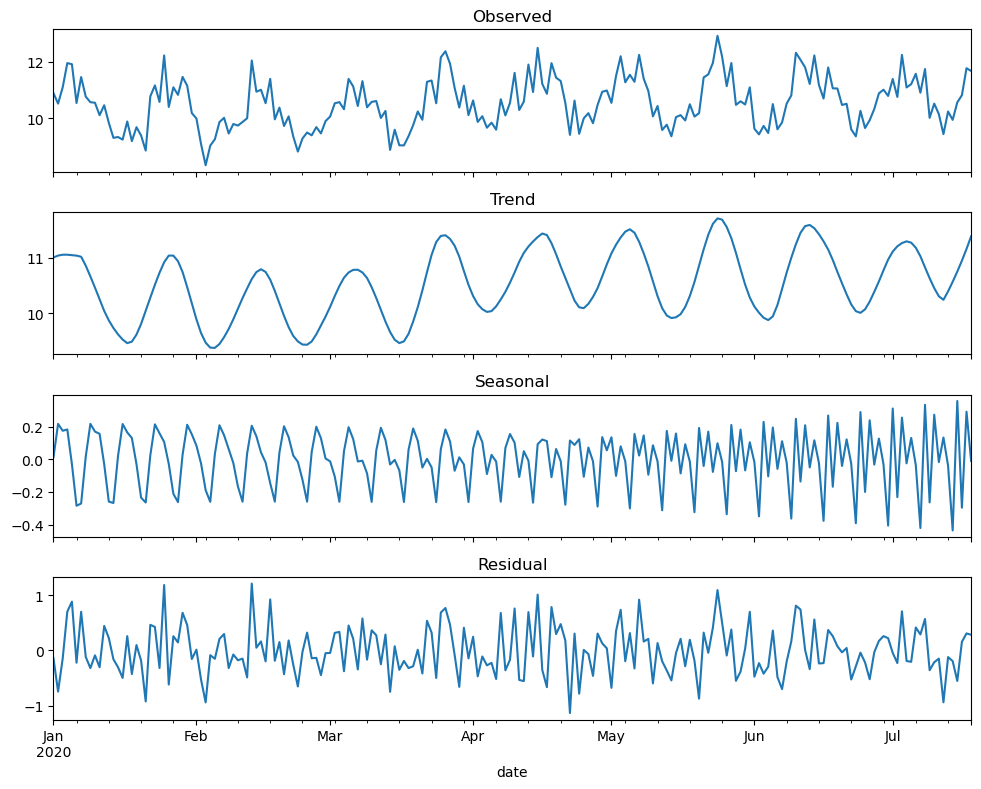

In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

# Step 1: Generate a synthetic time series data (or load your dataset)
np.random.seed(0)
n_points = 200
date_range = pd.date_range(start='2020-01-01', periods=n_points, freq='D')
data = {
    'date': date_range,
    'value': 10 + np.linspace(0, 1, n_points) + np.sin(np.linspace(0, 2 * np.pi * 10, n_points)) + np.random.normal(scale=0.5, size=n_points)
}
df = pd.DataFrame(data).set_index('date')

# Step 2: Perform STL decomposition
# Specify the seasonal period (e.g., 30 days for monthly seasonality in daily data)
stl = STL(df['value'], seasonal=31) # Need odd number of days because we need a center point with equal number of days on either side
result = stl.fit()

# Step 3: Plot the decomposed components
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
result.observed.plot(ax=axes[0], title='Observed')
result.trend.plot(ax=axes[1], title='Trend')
result.seasonal.plot(ax=axes[2], title='Seasonal')
result.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

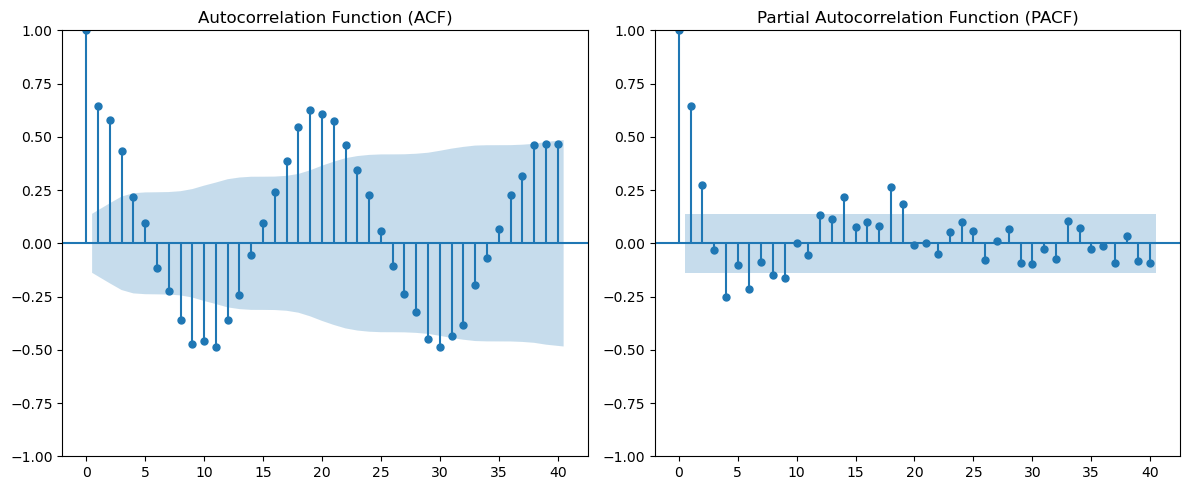

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Step 1: Generate a synthetic time series dataset (or use your existing data)
np.random.seed(0)
n_points = 200
date_range = pd.date_range(start='2020-01-01', periods=n_points, freq='D')
data = {
    'date': date_range,
    'value': 10 + np.linspace(0, 1, n_points) + np.sin(np.linspace(0, 2 * np.pi * 10, n_points)) + np.random.normal(scale=0.5, size=n_points)
}
df = pd.DataFrame(data).set_index('date')

# Step 2: Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Autocorrelation plot
plot_acf(df['value'], ax=axes[0], lags=40)
axes[0].set_title('Autocorrelation Function (ACF)')

# Partial Autocorrelation plot
plot_pacf(df['value'], ax=axes[1], lags=40, method='ywm')
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

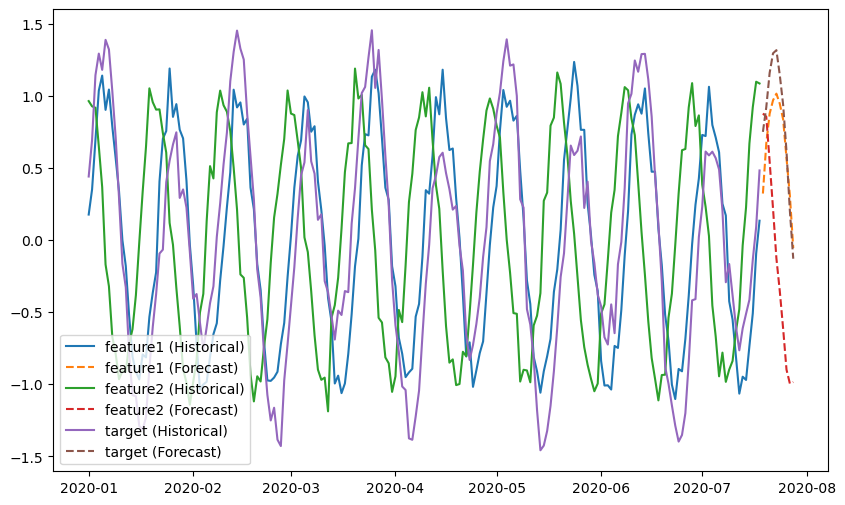

In [5]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

# Generate synthetic multivariate seasonal time series data
np.random.seed(0)
n_points = 200
date_range = pd.date_range(start='2020-01-01', periods=n_points, freq='D')
data = {
    'feature1': np.sin(np.linspace(0, 2 * np.pi * 10, n_points)) + np.random.normal(scale=0.1, size=n_points),
    'feature2': np.cos(np.linspace(0, 2 * np.pi * 10, n_points)) + np.random.normal(scale=0.1, size=n_points),
    'target': np.sin(np.linspace(0, 2 * np.pi * 10, n_points)) + 0.5 * np.cos(np.linspace(0, 2 * np.pi * 5, n_points)) + np.random.normal(scale=0.1, size=n_points)
}
df = pd.DataFrame(data, index=date_range)

# Seasonal differencing if needed
# df = df.diff(periods=30).dropna()

# Fit the VAR model
model = VAR(df)
model_fitted = model.fit(15)  # 15 lags for capturing seasonality and dependencies

# Forecasting the next 10 steps
forecast = model_fitted.forecast(df.values[-15:], steps=10)
forecast_df = pd.DataFrame(forecast, index=pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=10, freq='D'), columns=df.columns)

# Plot the forecast
plt.figure(figsize=(10, 6))
for col in df.columns:
    plt.plot(df.index, df[col], label=f'{col} (Historical)')
    plt.plot(forecast_df.index, forecast_df[col], '--', label=f'{col} (Forecast)')
plt.legend()
plt.show()

/Users/nserkes/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


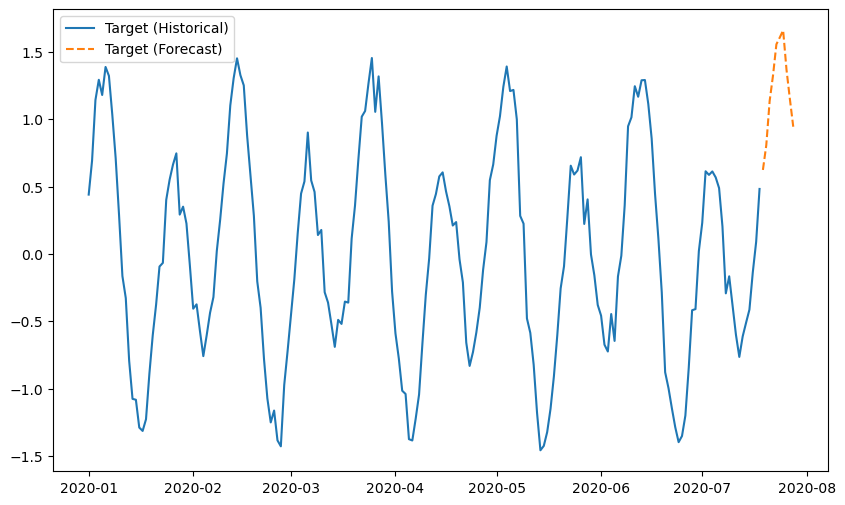

In [7]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMAX model for the target variable with exogenous variables feature1 and feature2
model = SARIMAX(df['target'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 20), exog=df[['feature1', 'feature2']])
model_fitted = model.fit(disp=False)

# Forecast the next 10 steps
forecast = model_fitted.get_forecast(steps=10, exog=df[['feature1', 'feature2']][-10:])
forecast_df = forecast.predicted_mean

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['target'], label='Target (Historical)')
plt.plot(forecast_df.index, forecast_df, '--', label='Target (Forecast)')
plt.legend()
plt.show()

When you get a “Maximum likelihood optimization failed to converge” warning in a SARIMAX model, it means that the iterative optimization algorithm used to estimate the model parameters was unable to find a stable solution within the allowed number of iterations or tolerance limits. In simple terms, the model couldn’t find parameter values that maximize the likelihood function, which is critical for making the model fit the data well.

This can happen for several reasons, and there are a few common ways to address it.

Causes of Convergence Issues

	1.	Inappropriate Model Specification:
	•	Incorrect choices for the AR, I, MA, or seasonal parameters (e.g., setting the model order or seasonal order too high) can make the optimization problem very complex or even unsolvable.
	•	For example, trying to model an ARIMA(5,1,5) with seasonal components can add too many parameters, making it harder for the algorithm to converge.
	2.	Insufficient Data:
	•	SARIMAX models typically require a large number of data points, especially if you are trying to model complex seasonality.
	•	If your data has a long seasonal period but a short series length, there might not be enough information to estimate the parameters effectively.
	3.	Non-Stationary Series:
	•	If the series is non-stationary and requires additional differencing, the model may have trouble converging. Non-stationary data can result in large parameter estimates that hinder convergence.
	•	Ensure that the data is appropriately differenced (both seasonally and non-seasonally) before fitting the SARIMAX model.
	4.	Parameter Initialization:
	•	SARIMAX models in statsmodels use numerical optimization to estimate the model parameters, and this process starts with initial guesses. Poor initial values can sometimes make it difficult for the optimizer to find the best parameters.
	5.	Multicollinearity with Exogenous Variables:
	•	If you’re using exogenous variables (in SARIMAX, often called exog), multicollinearity (high correlation between predictors) among those variables can cause instability in the optimization process.

How to Address Convergence Issues

	1.	Reduce the Complexity of the Model:
	•	Try using a simpler model with fewer parameters. For example, reduce the number of AR or MA terms (e.g., from ARIMA(5,1,5) to ARIMA(2,1,2)).
	•	Experiment with different values for the seasonal order. Often, a simpler model (e.g., with lower seasonal order) can provide good results without convergence issues.
	2.	Increase the Number of Iterations:
	•	By default, SARIMAX in statsmodels uses a limited number of iterations (usually around 50).
	•	You can increase the maxiter parameter in the .fit() function to allow the optimization to run longer.

Yes, you can replicate a seasonal autoregressive model with exogenous variables using OLS, Ridge, or Lasso regression by manually constructing lagged terms and seasonal indicators in your feature matrix. This approach is sometimes called “manual regression” or “feature engineering for time series” and allows you to use linear models to approximate the behavior of seasonal autoregressive models.

Here’s a step-by-step guide on how to replicate a SARIMAX-like model using ordinary least squares (OLS), Ridge, or Lasso.

Steps to Replicate a Seasonal Autoregressive Model with Exogenous Variables (SARIMAX) Using Linear Regression

	1.	Create Lagged Features: Generate lagged versions of the target variable to capture autoregressive (AR) relationships.
	2.	Create Seasonal Lags: Add seasonal lags to capture seasonal patterns (e.g., lag-12 for monthly seasonality).
	3.	Add Exogenous Variables: Include external (exogenous) variables in the feature matrix.
	4.	Choose Regression Method: Use OLS, Ridge, or Lasso for fitting the model. Ridge and Lasso can help if you have a large number of features or if regularization is needed.
	5.	Fit the Model: Train the model using the lagged and exogenous features.
	6.	Make Predictions: Use the model to predict future values.

Here’s an example using synthetic data to illustrate each step.

In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Step 1: Generate synthetic time series data with seasonality and exogenous variables
np.random.seed(0)
n_points = 200
date_range = pd.date_range(start='2020-01-01', periods=n_points, freq='D')
data = {
    'date': date_range,
    'target': np.sin(2 * np.pi * date_range.dayofyear / 365) + np.random.normal(scale=0.5, size=n_points),
    'exog1': np.random.normal(size=n_points),
    'exog2': np.random.normal(size=n_points)
}
df = pd.DataFrame(data).set_index('date')

# Step 2: Create lagged features for the target variable (e.g., 1-day and 7-day lags)
for lag in [1, 7, 30]:  # Include seasonal lags, e.g., lag-30 for monthly seasonality
    df[f'target_lag_{lag}'] = df['target'].shift(lag)

# Step 3: Include exogenous variables
# (Here, they are already present in `exog1` and `exog2` columns)

# Drop rows with NaN values created by lagging
df.dropna(inplace=True)

# Step 4: Split data into features (X) and target (y)
X = df[['target_lag_1', 'target_lag_7', 'target_lag_30', 'exog1', 'exog2']]
y = df['target']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 5: Choose the regression model (OLS, Ridge, or Lasso)
# Example using Ridge regression
model = Ridge(alpha=1.0)  # You can switch to LinearRegression() or Lasso(alpha=0.1)
model.fit(X_train, y_train)

# Step 6: Make predictions
y_pred = model.predict(X_test)

# Step 7: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

# Step 8: Display coefficients to interpret the impact of each feature
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
print(coefficients)

Mean Squared Error: 0.5480
         Feature  Coefficient
0   target_lag_1     0.158025
1   target_lag_7     0.215677
2  target_lag_30    -0.053284
3          exog1    -0.003036
4          exog2     0.001564


Explanation

	1.	Lagged Features:
	•	We created lagged versions of the target variable (target_lag_1, target_lag_7, and target_lag_30). These capture the autoregressive terms in the model, including a seasonal lag (lag-30) to simulate monthly seasonality.
	2.	Exogenous Variables:
	•	We added exogenous variables (exog1 and exog2) as additional predictors in the model.
	3.	Feature Matrix (X) and Target (y):
	•	We prepared the feature matrix X with lagged values and exogenous variables and set y as the current target value.
	4.	Train-Test Split:
	•	We split the data sequentially (without shuffling) since this is time series data.
	5.	Model Selection:
	•	We used Ridge(alpha=1.0) as an example, but you can replace it with LinearRegression() for OLS or Lasso(alpha=0.1) for Lasso regression.
	•	Regularization: Ridge and Lasso regression help control for multicollinearity and overfitting, especially useful when you have a large number of lags or exogenous variables.
	6.	Model Fitting and Prediction:
	•	We trained the model on the training set and predicted on the test set.
	7.	Evaluation:
	•	We calculated the Mean Squared Error (MSE) on the test set as an evaluation metric.
	8.	Interpretation:
	•	By printing the coefficients, you can see the influence of each feature (lagged values and exogenous variables) on the target. This helps interpret the impact of autoregressive terms, seasonal lags, and exogenous variables.

Notes

	•	Seasonal Lags: The target_lag_30 feature acts like the seasonal component in SARIMAX. If you have a different seasonality (e.g., weekly), adjust the lag accordingly.
	•	Choice of Model: If you’re unsure which regression method to use, you can try all three (OLS, Ridge, and Lasso) and compare performance. Ridge and Lasso are generally more stable when you have many features.
	•	Exogenous Variables: The exog1 and exog2 variables could represent any external influences, such as economic indicators, weather, or other contextual data.

Advantages and Limitations

Advantages

	•	Flexibility: You have control over which lags to include and can fine-tune the seasonal lags to match the specific periodicity in your data.
	•	Regularization: Ridge and Lasso offer regularization, which can help with feature selection and prevent overfitting, especially when you have many lags and exogenous variables.

Limitations

	•	Manual Lag Selection: Unlike SARIMAX, which automatically handles lags, you need to manually select and create lagged features, which may be challenging if seasonality is complex.
	•	Non-linear Relationships: If your data has non-linear relationships, OLS, Ridge, and Lasso may not capture these well. For more complex patterns, you might consider machine learning methods like Random Forests or LSTMs.
	•	Stationarity: Just as with SARIMAX, you may need to ensure stationarity in the target variable before fitting, either by differencing or detrending.

Summary

By manually creating lagged features and adding exogenous variables, you can use linear models like OLS, Ridge, or Lasso to approximate the behavior of a SARIMAX model. This approach allows for flexibility and interpretability but requires careful selection of lags and exogenous variables to capture seasonal patterns effectively.

## Feature Selection


Recursive Feature Elimination (RFE)

	•	Description: RFE recursively fits the model, removing the least important feature(s) at each iteration, until the desired number of features is left.
	•	How to Apply: Use RFE with your regression model (e.g., OLS, Ridge, or Lasso) to rank and select the top features based on importance.

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge

# Apply RFE with Ridge regression as the model
model = Ridge(alpha=1.0)
selector = RFE(model, n_features_to_select=5)  # Adjust n_features_to_select as needed
selector = selector.fit(X, y)

# Get the selected features
selected_features = X.columns[selector.support_]
print("Selected Features with RFE:", selected_features)

Cross-Validation with Stepwise Selection

	•	Description: Use cross-validation to iteratively add or remove features, selecting those that improve model performance. This method is sometimes called stepwise selection.
	•	How to Apply: Start with no features or with a simple set of features. At each step, add or remove one feature and evaluate model performance using cross-validation.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

def stepwise_selection(X, y, initial_features=[], threshold_in=0.05, threshold_out=0.1):
    included = list(initial_features)
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]  # all except constant
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)

        if not changed:
            break
    return included

selected_features = stepwise_selection(X, y)
print("Selected Features with Stepwise Selection:", selected_features)

Time-Series Cross-Validation with Feature Importances

	•	Description: Use time series cross-validation (e.g., TimeSeriesSplit) to evaluate each feature’s impact on model performance. You can assess feature importance by training models with and without each feature and measuring performance.
	•	How to Apply: Use cross-validation scores as indicators of feature importance. Alternatively, train models with and without subsets of features and see which combinations yield the best scores.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import Ridge

# Initialize TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5)

# Test each feature by calculating cross-validation scores
for feature in X.columns:
    X_subset = X[[feature]]
    model = Ridge(alpha=1.0)
    scores = cross_val_score(model, X_subset, y, cv=tss, scoring='neg_mean_squared_error')
    print(f"Feature: {feature}, CV Score: {np.mean(scores):.4f}")

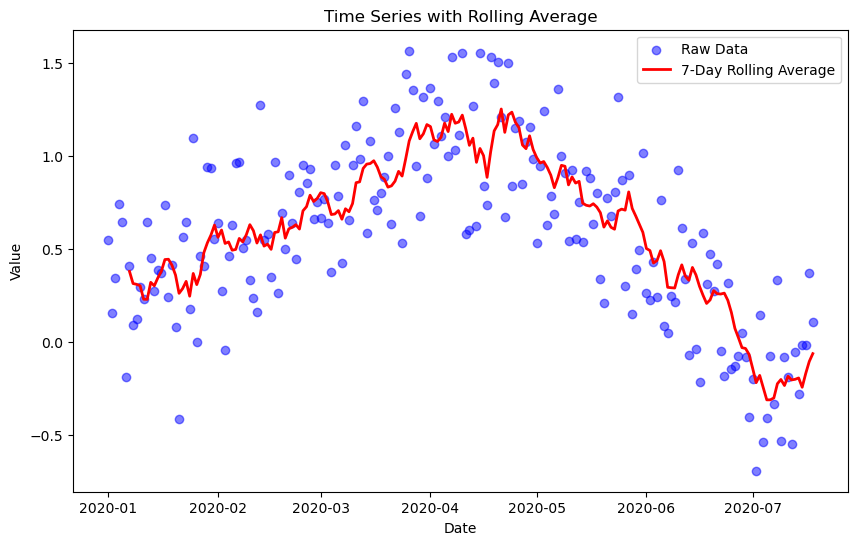

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Generate a sample time series dataset (or load your own data)
np.random.seed(0)
n_points = 200
date_range = pd.date_range(start='2020-01-01', periods=n_points, freq='D')
data = {
    'date': date_range,
    'value': np.sin(2 * np.pi * date_range.dayofyear / 365) + np.random.normal(scale=0.3, size=n_points)
}
df = pd.DataFrame(data).set_index('date')

# Calculate a rolling average (e.g., 7-day moving average)
window_size = 7
df['rolling_avg'] = df['value'].rolling(window=window_size).mean()

# Plot the scatter plot and rolling average
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['value'], color='blue', alpha=0.5, label='Raw Data')
plt.plot(df.index, df['rolling_avg'], color='red', linewidth=2, label=f'{window_size}-Day Rolling Average')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series with Rolling Average')
plt.legend()
plt.show()